In [1]:
import numpy as np
import pandas as pd
import copy

from croissance import process_curve
from croissance.estimation import fit_exponential
from croissance.estimation.util import normalize_time_unit
from croissance.figures import PDFWriter

import matplotlib.pyplot as plt

# the following codes define a function that extracts characteristic parameters from observed growth curves

In [2]:
def growth_curve_analysis(infile, unit_time):
    
    # "infile" is the relative/full path of the growth curve experimental data of 96-well plates
    # check 181109_glycerol_clinical.csv for input data format
    
    # unit_time is the unit of time
    # unit allowed: sec, min, hour
    
    # read data
    df = pd.read_excel(infile, index_col=0).squeeze()
    
    # convert time unit to hour
    if unit_time == 'sec':
        df.index = df[df.columns[0]]/3600
        df.index.names = ['Time (h)']
    if unit_time == 'min':
        df.index = df[df.columns[0]]/60
        df.index.names = ['Time (h)']
    
    # remove unnecessary columns
    #df = df.drop([df.columns[0],df.columns[1]], axis=1)

    # subtract baseline data (controls)
    # the baseline data is the mean of data in the first column and last column on the same row
    dfCopy = df.copy()
    for index, col in enumerate(dfCopy.columns):  
        indexOfFirstColumn = index % 8
        indexOfLastColumn = indexOfFirstColumn + 88
        toSubtract = (df.iloc[:,indexOfFirstColumn] + df.iloc[:,indexOfLastColumn])/2
        dfCopy.iloc[:,index] = dfCopy.iloc[:,index] - toSubtract
    
#     # remove baseline data: first (A1 to H1) and last columns (A12 to H12)
#     for letter in ['A','B','C','D','E','F','G','H']:
#         dfCopy = dfCopy.drop(letter+'1', axis=1)
#         dfCopy = dfCopy.drop(letter+'12', axis=1)
#     df = dfCopy
    
    # extract growth parameters using croissance
    rowList = []
    for index, col in enumerate(df.columns):  
        curve = df[col] # growth curve
        
        # the model fits lambda * exp(mu * t) + N0 to any candidate growth phases
        # of the growth curve that have increasing growth 
        # where
        # lambda is maximum growth rate
        # mu is growth rate
        # t is time
        # N0 is an offset, which can be constrained
        # we should constrain N0=0 after baseline correction
        results = process_curve(curve,constrain_n0=True, n0=0.)
    
        # croissance may identify multiple exponential phases with scores indicting how likely
        # each identified phase is exponential
        # we assume that the true growth phase has the longest time duration, rather than
        # the one with highest ranking
        MaxDuration = 0
        indexMaxDuration = -1
        for i, phase in enumerate(results.growth_phases):
            if phase.end-phase.start > MaxDuration:
                MaxDuration = phase.end-phase.start
                indexMaxDuration = i
    
        # the model returened from results is exp(slope * (t - intercept)) + N0
        # where mu = slope, lambda = 1/exp(slope * intercept)
        dict = {}
        
        # indexMaxDuraction equals to -1 if no exponential phase is found
        if indexMaxDuration >= 0:
            dict.update({'StartT': results.growth_phases[indexMaxDuration].start,
                     'EndT': results.growth_phases[indexMaxDuration].end,
                     'Duration': results.growth_phases[indexMaxDuration].end-results.growth_phases[indexMaxDuration].start,
                     'GrowthR': results.growth_phases[indexMaxDuration].slope,
                     'InitOD' : 1 / np.exp(results.growth_phases[indexMaxDuration].intercept * results.growth_phases[indexMaxDuration].slope),
                     'MaxOD': np.max(curve.values),
                     'FinalOD': curve.values[-1]})
        rowList.append(dict)
    
    dfGP = pd.DataFrame(rowList)
    dfGP = dfGP[['StartT','EndT','Duration','GrowthR','InitOD','MaxOD','FinalOD']]
    dfGP.index = df.columns
    
    return dfGP

# Let us use this function to extract growth parameters and visualize data fitting

In [22]:
df = growth_curve_analysis('181109_glycerol_clinical.xlsx', 'hour')
df

,StartT,EndT,Duration,GrowthR,InitOD,MaxOD,FinalOD
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1,4.741806,13.209278,8.467472,0.009769,0.074919,0.0959,0.0802
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1,0.000000,10.161000,10.161000,0.007880,0.073843,0.0895,0.0761
G1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,3.217639,21.846111,18.628472,0.119524,0.022613,0.8009,0.6963
B2,7.959444,20.830028,12.870583,0.128144,0.019586,0.9673,0.8319


In [19]:
df

,StartT,EndT,Duration,GrowthR,InitOD,MaxOD,FinalOD
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1,4.741806,13.209278,8.467472,0.009769,0.074919,0.0959,0.0802
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F1,0.000000,10.161000,10.161000,0.007880,0.073843,0.0895,0.0761
G1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2,3.217639,21.846111,18.628472,0.119524,0.022613,0.8009,0.6963
B2,7.959444,20.830028,12.870583,0.128144,0.019586,0.9673,0.8319


# the following codes overlays data and model fitting

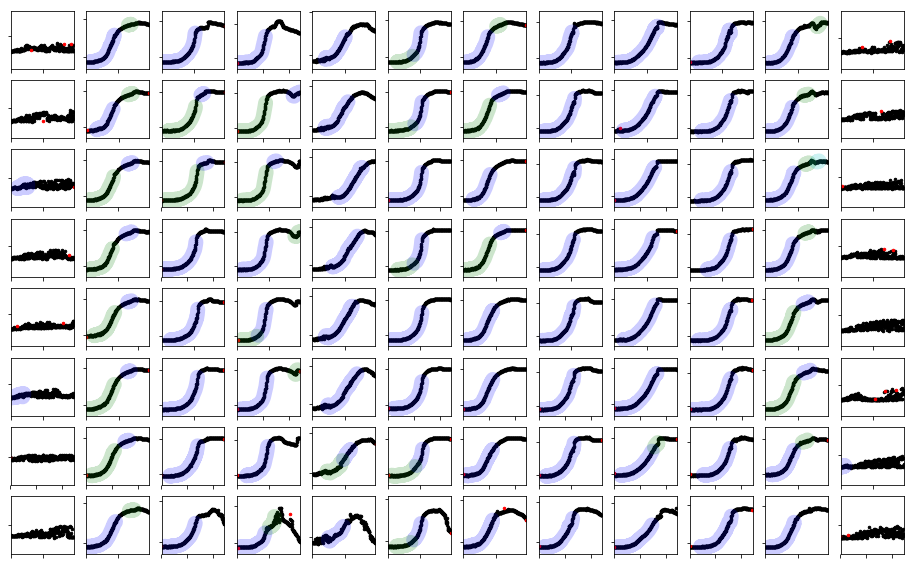

<Figure size 432x288 with 0 Axes>

In [14]:
infile = '181109_glycerol_clinical.xlsx'   
unit_time = 'hour'

df = pd.read_excel(infile, index_col=0).squeeze()
# convert time unit to hour
if unit_time == 'sec':
    df.index = df[df.columns[0]]/3600
    df.index.names = ['Time (h)']
if unit_time == 'min':
    df.index = df[df.columns[0]]/60
    df.index.names = ['Time (h)']

# subtract baseline data (controls)
# the baseline data is the mean of data in the first column and last column on the same row
dfCopy = df.copy()
for index, col in enumerate(dfCopy.columns):  
    indexOfFirstColumn = index % 8
    indexOfLastColumn = indexOfFirstColumn + 88
    toSubtract = (df.iloc[:,indexOfFirstColumn] + df.iloc[:,indexOfLastColumn])/2
    dfCopy.iloc[:,index] = dfCopy.iloc[:,index] - toSubtract
    
# plot
fig, axes = plt.subplots(nrows=8, ncols=12, figsize=(16, 10))
colors = ['b', 'g', 'c', 'm', 'y', 'k']
    
# extract growth parameters using croissance
rowList = []
for index, col in enumerate(df.columns):  
    curve = df[col] # growth curve
    results = process_curve(curve,constrain_n0=True, n0=0.)
        
    row_no = int(index % 8)
    col_no = int(np.floor(index/8))
                             
    axes[row_no, col_no].set_yscale('log')
    
    axes[row_no, col_no].plot(results.series.index,
                              results.series.values,
                              color='black',
                              marker='.',
                              markersize=5,
                              linestyle='None')

    axes[row_no, col_no].plot(results.outliers.index,
                              results.outliers.values,
                              color='red',
                              marker='.',
                              markersize=5,
                              linestyle='None')
    
    for i, phase in enumerate(results.growth_phases):
        color = colors[i % len(colors)]
        a = 1 / np.exp(phase.intercept * phase.slope)

        def gf(x):
            return a * np.exp(phase.slope * x) + phase.n0

        phase_series = results.series[phase.start:phase.end]
        #axes[row_no, col_no].axhline(y=phase.n0, marker=None, linewidth=1, linestyle='dashed', color=color)
        #axes[row_no, col_no].axvline(x=phase.intercept, marker=None, linewidth=1, linestyle='dashed', color=color)

        axes[row_no, col_no].plot(phase_series.index,
                                  phase_series.values,
                                  marker=None,
                                  linewidth=15,
                                  color=color,
                                  solid_capstyle='round',
                                  alpha=0.2)

        #axes[row_no, col_no].plot(results.series.index, gf(results.series.index), color=color, linewidth=1)
        #axes[row_no, col_no].plot(phase_series.index, gf(phase_series.index), color=color, linewidth=2)

    axes[row_no, col_no].set_xlim(results.series.index[0], results.series.index[-1])
    axes[row_no, col_no].set_ylim([0.05, results.series.max()*2])
    
    axes[row_no, col_no].set_xticklabels([])
    axes[row_no, col_no].set_yticklabels([]) 
    
    axes[row_no, col_no].minorticks_off()

plt.show()
plt.tight_layout()